In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [2]:
def denoiseFile(imageName):
    image = cv2.imread(imageName)
    denoisedImage = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 10, 15)
    # denoisedImage = cv2.fastNlMeansDenoisingColored(image, None, 8, 8, 7, 15)

    # plt.subplot(121)    # For some reason MatPlotLib adds a blue tint to my images when displaying them.
    # plt.imshow(image)
    # plt.subplot(122)
    # plt.imshow(denoisedImage)

    # plt.show()

    cv2_imshow(image)
    cv2_imshow(denoisedImage)
    cv2.waitKey(0)
    return denoisedImage

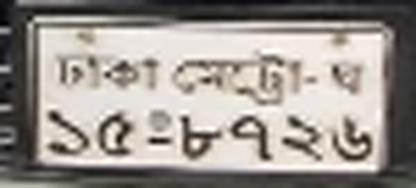

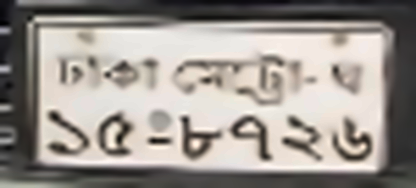

In [3]:
denoisedImage=denoiseFile("/content/drive/MyDrive/Colab Notebooks/test/110_78_1_jpg.rf.d7fe68d3205b26fe2a8f82ec749245d3.jpg")

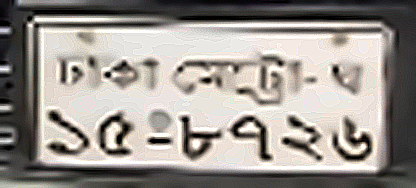

In [4]:
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(denoisedImage, -1, sharpen_kernel)
cv2_imshow(sharpen)

In [5]:
!pip install torch torchvision pillow

In [16]:
def segment_plates(mat, coordinates, only_first=True):
    plates = []
    for coordinate in coordinates:
        # actual corners
        src_corners = np.full((4, 2), 0, dtype=np.float32)
        topl = src_corners[0] = coordinate[0]
        topr = src_corners[1] = coordinate[1]
        bottomr = src_corners[2] = coordinate[2]
        bottoml = src_corners[3] = coordinate[3]

        # topl = coordinate[0]
        # topr = coordinate[1]
        # bottomr = coordinate[2]
        # bottoml = coordinate[3]

        # calc the maxwidth & maxheight for affine transformation
        bottom_width = np.sqrt(((bottomr[0] - bottoml[0]) ** 2) + ((bottomr[1] - bottoml[1]) ** 2))
        top_width = np.sqrt(((topr[0] - topl[0]) ** 2) + ((topr[1] - topl[1]) ** 2))
        right_height = np.sqrt(((topr[0] - bottomr[0]) ** 2) + ((topr[1] - bottomr[1]) ** 2))
        left_height = np.sqrt(((topl[0] - bottoml[0]) ** 2) + ((topl[1] - bottoml[1]) ** 2))
        max_width = max(int(bottom_width), int(top_width))
        max_height = max(int(right_height), int(left_height))

        # corners after transformation
        # http://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#getperspectivetransform
        dst_corners = np.array([[0, 0], [max_width - 1, 0], [max_width - 1, max_height - 1], [0, max_height - 1]],
                               dtype="float32")
        transformation_matrix = cv2.getPerspectiveTransform(src_corners, dst_corners)
        roi = cv2.warpPerspective(mat, transformation_matrix, (max_width, max_height))
        plates.append(roi)

        if only_first:
            break

    return plates


def draw_segmentation_mask(w, h, contours, selected):
    bin_cnt = np.zeros((h, w), np.uint8)
    for i, cnt in enumerate(contours):
        rx, ry, rw, rh = cv2.boundingRect(cnt)
        if i in selected:
            rxf = rx + rw - 1
            ryf = ry + rh - 1
            cv2.rectangle(bin_cnt, (rx, ry), (rxf, ryf), 255, -1)
    return bin_cnt


def process_mask(gray, rectangles_mask, min_contour_area=20):
    h, w = gray.shape
    final = np.zeros((h, w), np.uint8)
    final = cv2.bitwise_not(final)
    image, contours, hierarchy = cv2.findContours(rectangles_mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    for i, cnt in enumerate(contours):
        rx, ry, rw, rh = cv2.boundingRect(cnt)
        rxf = rx + rw - 1
        ryf = ry + rh - 1

        _, character = cv2.threshold(gray[ry:ryf, rx:rxf], 0, 255, cv2.THRESH_OTSU)
        # print("character")
        # _, character_contours, _ = cv2.findContours(character, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
        # for _, character_cnt in enumerate(character_contours):
        #     contour_area = cv2.contourArea(character_cnt)
        #     print(contour_area)
        #     if contour_area > min_contour_area:
        #         final[ry:ryf, rx:rxf] = character
        final[ry:ryf, rx:rxf] = character
    return final



def clean_img_bin(img_bin, min_area, max_area):
    h, w = img_bin.shape
    _, character_contours, _ = cv2.findContours(img_bin, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros((h, w), np.uint8)
    for i, character_cnt in enumerate(character_contours):
        contour_area = cv2.contourArea(character_cnt)
        if min_area < contour_area < max_area:
            cv2.drawContours(mask, character_contours, i, (255, 255, 255), cv2.FILLED, 8)
    final2 = cv2.bitwise_and(img_bin, img_bin, mask=mask)
    bk = cv2.bitwise_not(np.zeros((h, w), np.uint8))
    final2_bk = cv2.bitwise_and(bk, bk, mask=cv2.bitwise_not(mask))
    return cv2.bitwise_or(final2, final2_bk)

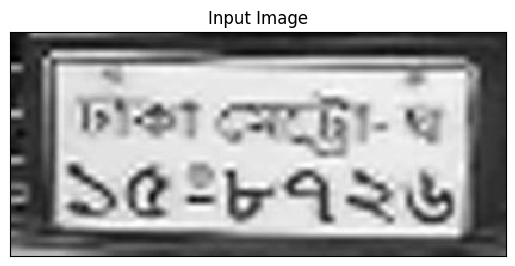

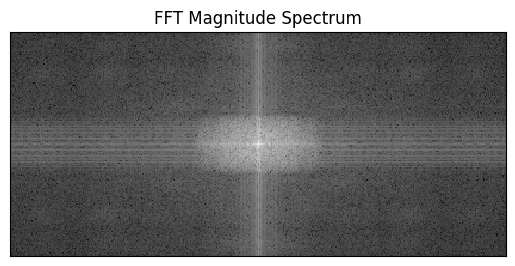

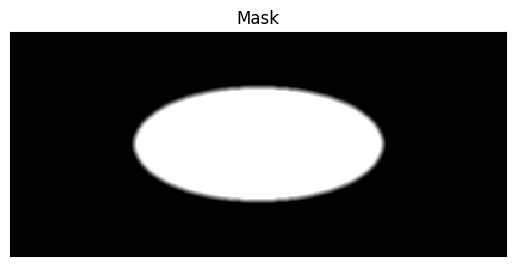

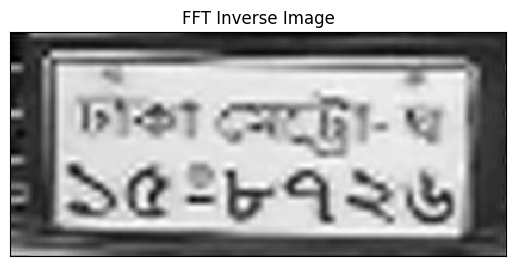

In [17]:
import os
import cv2
import matplotlib.pyplot as plt

import numpy as np

img_path = "/content/drive/MyDrive/Colab Notebooks/test/110_78_1_jpg.rf.d7fe68d3205b26fe2a8f82ec749245d3.jpg"


# points = []
# points_path = img_path + '.pkz'
# if os.path.exists(points_path):
#     points = roi.retrieve(points_path, decompress=False)
# else:
#     print(img_path, ' points file for plate not found')
#     exit(1)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
h, w = gray.shape

# magnitude_spectrum = noise.cv2_fft_magnitude(gray)
dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = np.log(1 + cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

f_ishift = np.fft.ifftshift(dft_shift)
img_back = cv2.idft(f_ishift, flags=cv2.DFT_COMPLEX_OUTPUT | cv2.DFT_SCALE)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.imshow(gray, cmap = 'gray', interpolation='none')
plt.show()

plt.title('FFT Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.imshow(magnitude_spectrum, cmap = 'gray', interpolation='none')
plt.show()

mask = np.zeros((h, w),np.float32)
cv2.ellipse(mask, center=(w>>1, h>>1), axes=(w>>2, h>>2), angle=0, startAngle=0, endAngle=360, color=255, thickness=-1)
mask = cv2.blur(mask, (5,5), borderType=cv2.BORDER_REPLICATE)
mask = cv2.normalize(mask, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.imshow(mask, cmap = 'gray', interpolation='none')
plt.show()

mask3d = np.zeros((h, w, 2), np.float32)
mask3d[:, :, 0] = mask[:, :]
mask3d[:, :, 1] = mask[:, :]
dft_shift_masked = dft_shift * mask3d
magnitude_spectrum_masked = np.log(1 + cv2.magnitude(dft_shift_masked[:, :, 0], dft_shift_masked[:, :, 1]))

f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv2.idft(f_ishift, flags=cv2.DFT_COMPLEX_OUTPUT | cv2.DFT_SCALE)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

plt.title('FFT Inverse Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img_back, cmap = 'gray', interpolation='none')
plt.show()

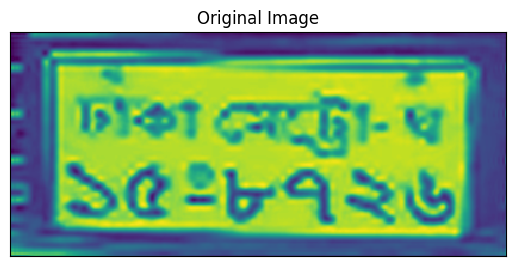

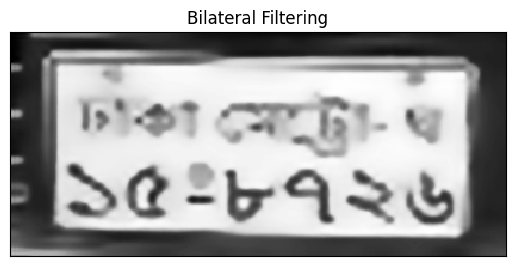

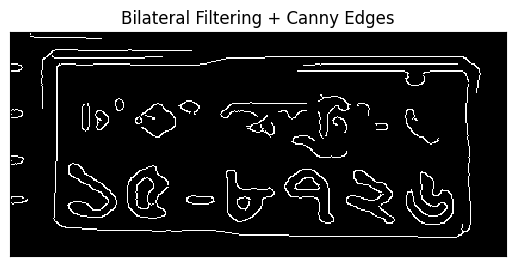

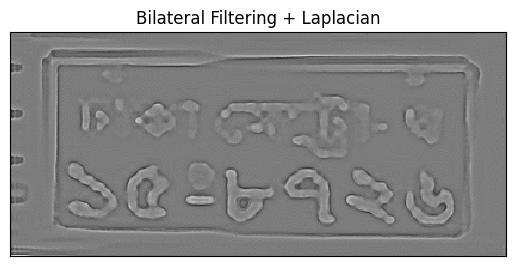

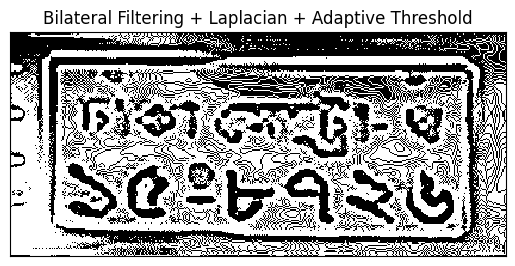

In [18]:
wsize = gray.shape[0]>>3
filtered = cv2.bilateralFilter(img_back, wsize, 30, wsize)

plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img_back, interpolation='none')
plt.show()

plt.title('Bilateral Filtering'), plt.xticks([]), plt.yticks([])
plt.imshow(filtered, cmap='gray', interpolation='none')
plt.show()

# binarization
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged
filtered_bin = auto_canny(filtered)
plt.title('Bilateral Filtering + Canny Edges'), plt.xticks([]), plt.yticks([])
plt.imshow(filtered_bin, cmap = 'gray', interpolation='none')
plt.show()

laplacian = cv2.Laplacian(filtered, cv2.CV_64F)
laplacian = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(laplacian, cmap = 'gray', interpolation='none')
plt.title('Bilateral Filtering + Laplacian'), plt.xticks([]), plt.yticks([])
plt.show()

window_size = ((h>>1)<<1)+1
img_bin = cv2.adaptiveThreshold(laplacian, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, window_size, 0)
plt.imshow(img_bin, cmap = 'gray', interpolation='none')
plt.title('Bilateral Filtering + Laplacian + Adaptive Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

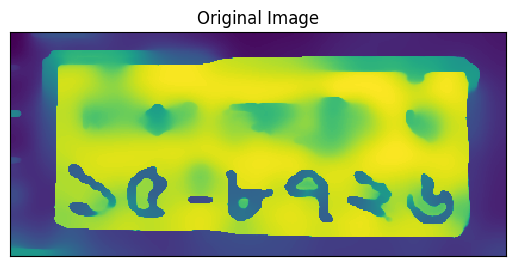

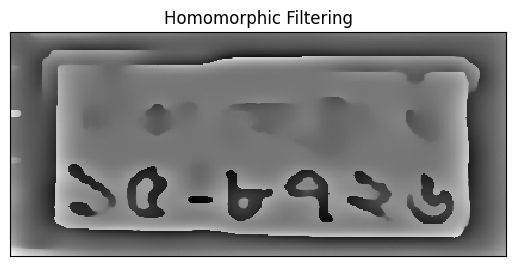

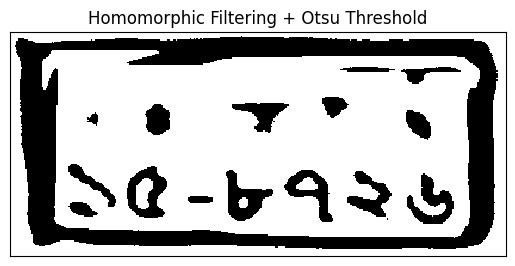

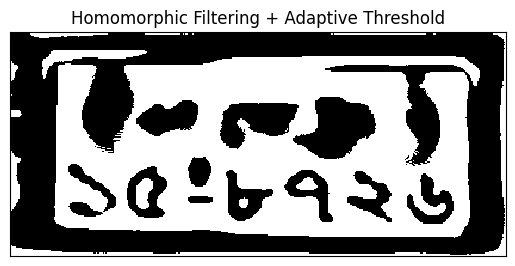

In [23]:
wsize = h>>3
gray = cv2.bilateralFilter(gray, wsize, 30, wsize)

# noise filtering
from scipy.fftpack import fft, ifft
def homomorphic(gray, low_gamma=0.3, high_gamma=1.5):
    img = gray
    rows, cols = gray.shape

    # based on this excellent answer: http://stackoverflow.com/a/24732434/2692914
    imgLog = np.log1p(np.array(img, dtype="float") / 255)

    M = 2 * rows + 1
    N = 2 * cols + 1
    sigma = 10
    (X, Y) = np.meshgrid(np.linspace(0, N - 1, N), np.linspace(0, M - 1, M))
    centerX = np.ceil(N / 2)
    centerY = np.ceil(M / 2)
    gaussianNumerator = (X - centerX) ** 2 + (Y - centerY) ** 2

    Hlow = np.exp(-gaussianNumerator / (2 * sigma * sigma))
    Hhigh = 1 - Hlow

    HlowShift = scipy.fftpack.ifftshift(Hlow.copy())
    HhighShift = scipy.fftpack.ifftshift(Hhigh.copy())

    # divides la imagen en alta frecuencia y baja frecuencia
    If = scipy.fftpack.fft2(imgLog.copy(), (M, N))
    Ioutlow = scipy.fftpack.ifft2(If.copy() * HlowShift, (M, N)).real
    Iouthigh = scipy.fftpack.ifft2(If.copy() * HhighShift, (M, N)).real


    # las unes con diferentes coeficientes
    gamma1 = low_gamma
    gamma2 = high_gamma
    Ioutlow_gamma = gamma1 * Ioutlow[0:rows, 0:cols]
    Iouthigh_gamma = gamma2 * Iouthigh[0:rows, 0:cols]
    Iout = Ioutlow_gamma + Iouthigh_gamma

    Ihmf = np.expm1(Iout)
    Ihmf = (Ihmf - np.min(Ihmf)) / (np.max(Ihmf) - np.min(Ihmf))
    return np.array(255 * Ihmf, dtype="uint8")
filtered = homomorphic(gray, 0.1, 1.)

plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.imshow(gray, interpolation='none')
plt.show()

plt.title('Homomorphic Filtering'), plt.xticks([]), plt.yticks([])
plt.imshow(filtered, cmap='gray', interpolation='none')
plt.show()

# binarization
_, filtered_bin = cv2.threshold(filtered, 0, 255, cv2.THRESH_OTSU)
plt.imshow(filtered_bin, cmap = 'gray', interpolation='none')
plt.title('Homomorphic Filtering + Otsu Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

window_size = ((h>>1)<<1)+1
filtered_bin = cv2.adaptiveThreshold(filtered, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_MEAN_C, window_size, 0)
plt.imshow(filtered_bin, cmap = 'gray', interpolation='none')
plt.title('Homomorphic Filtering + Adaptive Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

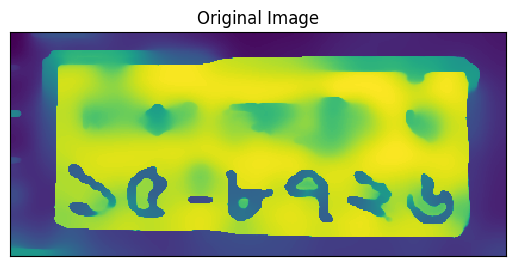

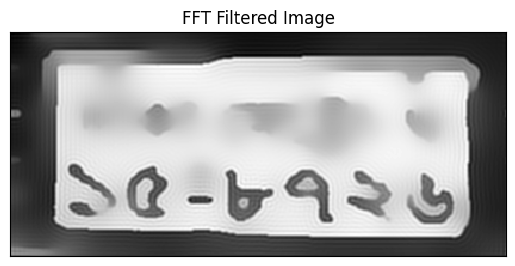

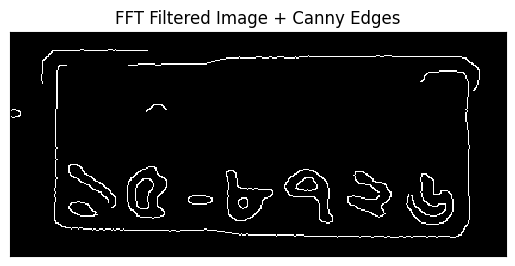

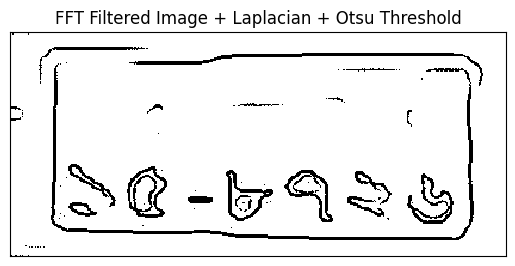

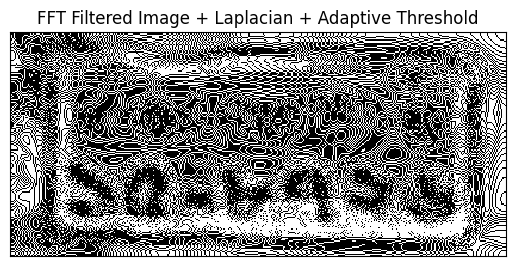

In [28]:
mask = np.zeros((h, w), np.float32)
cv2.ellipse(mask, center=(w >> 1, h >> 1), axes=(w >> 2, h >> 2), angle=0, startAngle=0, endAngle=360, color=255,
            thickness=-1)
mask = cv2.blur(mask, (5, 5), borderType=cv2.BORDER_REPLICATE)
mask = cv2.normalize(mask, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

def fft_filter(gray, mask):
    h, w = gray.shape

    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    # magnitude_spectrum = np.log(1 + cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

    mask3d = np.zeros((h, w, 2), np.float32)
    mask3d[:, :, 0] = mask[:, :]
    mask3d[:, :, 1] = mask[:, :]
    dft_shift_masked = dft_shift * mask3d
    # magnitude_spectrum_masked = np.log(1 + cv2.magnitude(dft_shift_masked[:, :, 0], dft_shift_masked[:, :, 1]))

    f_ishift = np.fft.ifftshift(dft_shift_masked)
    img_back = cv2.idft(f_ishift, flags=cv2.DFT_COMPLEX_OUTPUT | cv2.DFT_SCALE)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    return cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
filtered = fft_filter(gray, mask)

plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.imshow(gray, interpolation='none')
plt.show()

plt.title('FFT Filtered Image'), plt.xticks([]), plt.yticks([])
plt.imshow(filtered, cmap='gray', interpolation='none')
plt.show()


# binarization
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged
filtered_blurred = cv2.GaussianBlur(filtered, (5, 5), 0)
filtered_blurred_bin = auto_canny(filtered_blurred)
plt.title('FFT Filtered Image + Canny Edges'), plt.xticks([]), plt.yticks([])
plt.imshow(filtered_blurred_bin, cmap = 'gray', interpolation='none')
plt.show()


filtered_blurred = cv2.GaussianBlur(filtered, (5, 5), 0)
img_back_gray_filtered = cv2.Laplacian(filtered_blurred, cv2.CV_64F)
img_back_gray_filtered = cv2.normalize(img_back_gray_filtered, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
threshold, img_back_bin = cv2.threshold(img_back_gray_filtered, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('FFT Filtered Image + Laplacian + Otsu Threshold'), plt.xticks([]), plt.yticks([])
plt.show()


window_size = ((h>>1)<<1)+1

# filtered_blurred = cv2.GaussianBlur(filtered, ((window_size>>2)+1, (window_size>>2)+1), 0)
gx = int(window_size/5)
gy = int(window_size/5)
filtered_blurred = cv2.GaussianBlur(filtered, (gx, gy), 0)
img_back_gray_filtered = cv2.Laplacian(filtered_blurred, cv2.CV_64F)
img_back_gray_filtered = cv2.normalize(img_back_gray_filtered, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

img_back_bin = cv2.adaptiveThreshold(img_back_gray_filtered, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, window_size, 0)
plt.imshow(img_back_bin, cmap = 'gray', interpolation='none')
plt.title('FFT Filtered Image + Laplacian + Adaptive Threshold'), plt.xticks([]), plt.yticks([])
plt.show()